In [1]:
import numpy as np

from classy import Class    # CLASS python
import jax_cosmo as jc      # Jax-cosmo lib
import pyccl as ccl         # CCL python
from jemupk import *        # Jax Emulator of CLASS

In [54]:
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('image', cmap='jet')
import matplotlib.patches as mpatches
mpl.rcParams['font.size'] = 20

In [3]:
import settings_gfpkq_120x20  as st         # configuration file (update 2/June/22)

In [4]:
print(f"(k,z)-grid: {st.nk}x{st.nz}")

(k,z)-grid: 120x20


In [5]:
# Set emulator parameters
param_emu = {}

param_emu['kernel_gf_kscale'] = kernel_Matern12
param_emu['kernel_pklin'] = kernel_RBF
param_emu['kernel_pknl']  = kernel_RBF
param_emu['kernel_qfunc_bis'] = kernel_Matern12

param_emu['zmin'] = st.zmin
param_emu['zmax'] = st.zmax
param_emu['nz']   = st.nz

param_emu['kmin'] = st.k_min_h_by_Mpc
param_emu['kmax'] = st.k_max_h_by_Mpc
param_emu['nk']   = st.nk

param_emu['order'] = st.order
param_emu['x_trans'] = st.x_trans

param_emu['gf_kscale_y_trans'] = st.gf_scale_args['y_trans']
param_emu['pl_y_trans'] = st.pl_args['y_trans']
param_emu['pnl_y_trans']       = st.pnl_args['y_trans']
param_emu['qf_bis_y_trans']    = st.qf_bis_args['y_trans']


param_emu['use_mean'] = st.use_mean

root_dir = "./"
if st.sigma8:
    print("Using: Omega_cdm h^2, Omega_b h^2, sigma8, ns, h")
    tag='_sig8_'  + str(st.nk) + "x" + str(st.nz)  
else:
    raise NotImplementedError("No more in use")
param_emu['load_dir'] = root_dir + '/pknl_components' + st.d_one_plus+tag

Using: Omega_cdm h^2, Omega_b h^2, sigma8, ns, h


In [6]:
emu = JemuPk(param_emu)

In [8]:
cosmo_jc = jc.Planck15()

In [10]:
h_emu = cosmo_jc.h
omega_c_emu =  cosmo_jc.Omega_c * h_emu**2
omega_b_emu = cosmo_jc.Omega_b * h_emu**2
sigma8_emu = cosmo_jc.sigma8
n_s_emu = cosmo_jc.n_s


Omega_c_ccl = omega_c_emu/h_emu**2
Omega_b_ccl = omega_b_emu/h_emu**2

cosmo_ccl = ccl.Cosmology(
    Omega_c=Omega_c_ccl, Omega_b=Omega_b_ccl, 
    h=h_emu, n_s=n_s_emu, sigma8 = sigma8_emu,
    transfer_function='eisenstein_hu', matter_power_spectrum='halofit')


In [11]:
cosmo_ccl

pyccl.Cosmology(Omega_c=0.2589, Omega_b=0.0486, h=0.6774, n_s=0.9667, sigma8=0.8159, A_s=None, Omega_k=0.0, Omega_g=None, Neff=3.046, w0=-1.0, wa=0.0, T_CMB=None, bcm_log10Mc=14.079181246047625, bcm_etab=0.5, bcm_ks=55.0, mu_0=0.0, sigma_0=0.0, c1_mg=1.0, c2_mg=1.0, lambda_mg=0.0, extra_parameters=None, m_nu=0.0, m_nu_type=None, z_mg=None, df_mg=None, transfer_function='eisenstein_hu', matter_power_spectrum='halofit', baryons_power_spectrum='nobaryons', mass_function='tinker10', halo_concentration='duffy2008', emulator_neutrinos='strict')

In [13]:
cosmo_jax = jc.Cosmology(Omega_c=Omega_c_ccl, Omega_b=Omega_b_ccl, 
    h=h_emu, sigma8=sigma8_emu, n_s=n_s_emu, Omega_k=0, w0=-1.0,wa=0.0)

In [55]:
Nk=10*st.nk 
k_star = jnp.geomspace(st.k_min_h_by_Mpc, 20.,Nk, endpoint=True) #h/Mpc
z_star = jnp.array([0.,1., 2., 3.])
pk_linear_interp = emu.linear_pk(cosmo_jax, k_star,z_star)
pk_nonlin_interp = emu.nonlinear_pk(cosmo_jax,k_star, z_star)

In [56]:
pk_linear_interp.shape, pk_nonlin_interp.shape

((4, 1200), (4, 1200))

In [57]:
# CCL & Jax-cosmo

In [58]:
zbin=2
z_ccl = z_star[zbin].item()

print("z_ccl=",z_ccl)

pk_lin_ccl = ccl.linear_matter_power(cosmo_ccl, k_star*cosmo_jax.h, 1./(1+z_ccl)) #last is scale factor 1=>z=0
pk_lin_jc = jc.power.linear_matter_power(cosmo_jax,k_star, 1./(1+z_ccl))/cosmo_jax.h**3

z_ccl= 2.0


In [44]:
# Classy

In [60]:
st.fixed_nm['M_tot']

0.06

In [61]:
params_def_classy = {
    'output': 'mPk',
    'n_s': n_s_emu, 
    'h': h_emu,
    'omega_b': omega_b_emu,
    'omega_cdm':omega_c_emu,
    'N_ncdm': 1.0, 
    'deg_ncdm': 3.0, 
    'T_ncdm': 0.71611, 
    'N_ur': 0.00641,
    'm_ncdm':0.02,
    'z_max_pk' :  st.zmax,
    'P_k_max_h/Mpc' : st.k_max_h_by_Mpc_TrainingMaker,
    'halofit_k_per_decade' : 80.,
    'halofit_sigma_precision' : 0.05
    }

if st.sigma8:
    params_def_classy['sigma8']=sigma8_emu
else:
    raise NotImplementedError("No more in use") #params_def_classy['A_s']=As_emu,

#Neutrino default
params_def_classy['m_ncdm'] = st.fixed_nm['M_tot']/params_def_classy['deg_ncdm']


params_classy_lin =  params_def_classy.copy()
params_classy_lin['non_linear'] = 'none'

params_classy_nl =  params_def_classy.copy()
params_classy_nl['non_linear'] = 'halofit'

In [62]:
class_module_lin = Class()
class_module_lin.set(params_classy_lin)
class_module_lin.compute()


class_module_nl = Class()
class_module_nl.set(params_classy_nl)
class_module_nl.compute()


In [63]:
pk_class_lin = np.array([class_module_lin.pk(k * h_emu, z_ccl) for k in k_star])

In [64]:
pk_class_nl  = np.array([class_module_nl.pk(k * h_emu, z_ccl) for k in k_star])

pk_nonlin_ccl = ccl.nonlin_matter_power(cosmo_ccl, k_star*cosmo_jax.h, 
                                        1./(1+z_ccl)) #last is scale factor 1=>z=0


pk_nonlin_jc = jc.power.nonlinear_matter_power(cosmo_jax,k_star, 
                                               1./(1+z_ccl))/cosmo_jax.h**3

In [50]:
# Clean CLASS memory
#class_module_lin.struct_cleanup()
#class_module_lin.empty()
#class_module_nl.struct_cleanup()
#class_module_nl.empty()

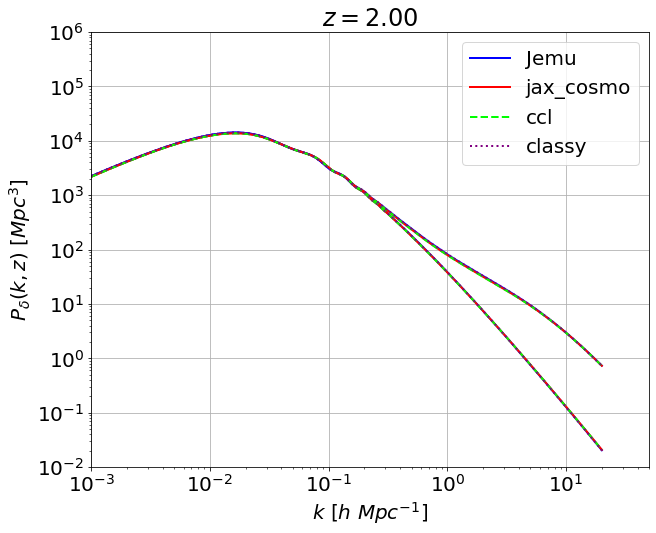

In [66]:
plt.figure(figsize=(10,8))
###plt.plot(k_train,pk_linear[:,zbin],lw=2, c="b", label="Jemu")
###plt.plot(k_train,pk_lin_jc,lw=2, c="r", label="jax_cosmo")
###plt.plot(k_train,pk_lin_ccl,lw=2, ls="--", c="lime", label=r"ccl")
###plt.plot(k_train,pk_class_lin,lw=2, ls=":", c="purple",label="classy")

plt.plot(k_star,pk_linear_interp[zbin,:],lw=2, c="b", label="Jemu")
plt.plot(k_star,pk_lin_jc,lw=2, c="r", label="jax_cosmo")
plt.plot(k_star,pk_lin_ccl,lw=2, ls="--", c="lime", label=r"ccl")
plt.plot(k_star,pk_class_lin,lw=2, ls=":", c="purple",label="classy")



plt.plot(k_star,pk_nonlin_interp[zbin],lw=2, c="b")#, label=r"$P_{{nl}}$ (Jemu)")
plt.plot(k_star,pk_nonlin_jc,lw=2, c="r")#, label=r"$P_{{nl}}$ (jax_cosmo)")
plt.plot(k_star,pk_nonlin_ccl,lw=2, ls="--",c="lime")#,label=r"$P_{{nl}}$ (ccl)")
plt.plot(k_star,pk_class_nl,lw=2, ls=":", c="purple")#,label="classy")
plt.legend()
plt.xscale("log")
plt.yscale("log")
plt.xlabel(r"$k\ [h\ Mpc^{-1}]$")
plt.ylabel(r"$P_\delta(k,z)\ [Mpc^3]$")
plt.grid()
plt.title(rf"$z={z_ccl:.2f}$");
plt.xlim([1e-3,5e1])
plt.ylim([1e-2,1e6]);

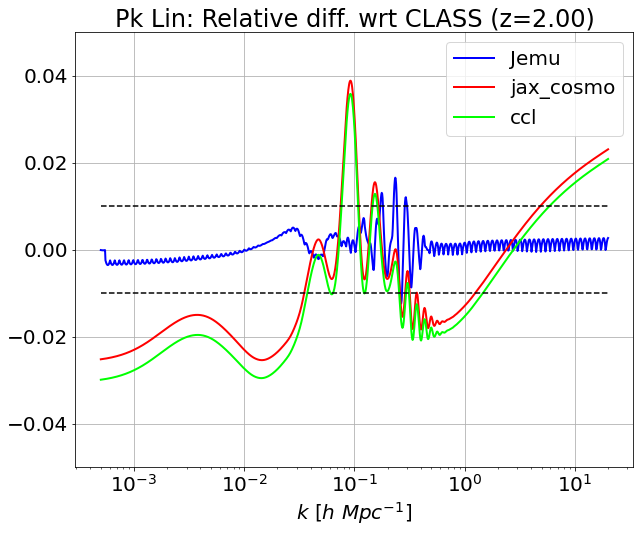

In [67]:
plt.figure(figsize=(10,8))
plt.plot(k_star,(pk_linear_interp[zbin,:]-pk_class_lin)/pk_class_lin,lw=2, c="b", label="Jemu")
plt.plot(k_star,(pk_lin_jc-pk_class_lin)/pk_class_lin,lw=2, c="r", label="jax_cosmo")
plt.plot(k_star,(pk_lin_ccl-pk_class_lin)/pk_class_lin,lw=2, c="lime", label="ccl")
plt.legend()
plt.grid()
plt.xscale("log");

plt.ylim([-0.05,0.05])
plt.plot([k_star.min(),k_star.max()],[-0.01,-0.01],c='k',ls='--')
plt.plot([k_star.min(),k_star.max()],[0.01,0.01],c='k',ls='--')
plt.xlabel(r"$k\ [h\ Mpc^{-1}]$")

plt.title(f"Pk Lin: Relative diff. wrt CLASS (z={z_ccl:.2f})");

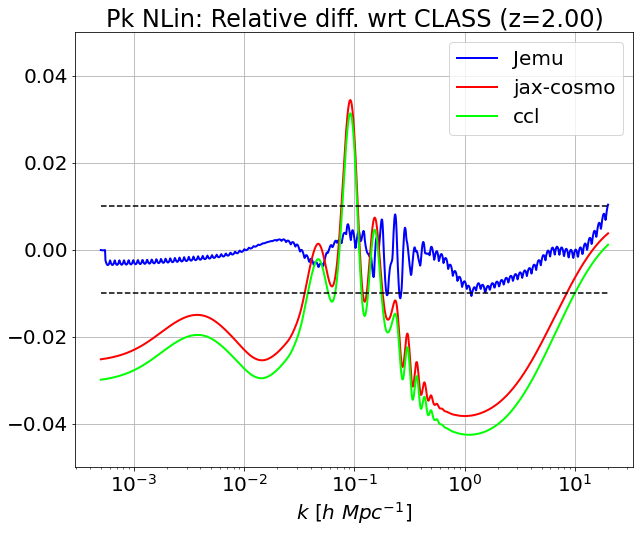

In [71]:
plt.figure(figsize=(10,8))

plt.plot(k_star,(pk_nonlin_interp[zbin]-pk_class_nl)/pk_class_nl,lw=2, c="b", label="Jemu")#, label=r"$P_{{nl}}$ (Jemu)")
plt.plot(k_star,(pk_nonlin_jc-pk_class_nl)/pk_class_nl,lw=2, c="r", label="jax-cosmo")#, label=r"$P_{{nl}}$ (jax_cosmo)")
plt.plot(k_star,(pk_nonlin_ccl-pk_class_nl)/pk_class_nl,lw=2,c="lime",  label="ccl")#,label=r"$P_{{nl}}$ (ccl)")
plt.grid()
plt.legend()
plt.xscale("log")
plt.ylim([-0.05,0.05])
plt.plot([k_star.min(),k_star.max()],[-0.01,-0.01],c='k',ls='--')
plt.plot([k_star.min(),k_star.max()],[0.01,0.01],c='k',ls='--')
plt.xlabel(r"$k\ [h\ Mpc^{-1}]$")

plt.title(f"Pk NLin: Relative diff. wrt CLASS (z={z_ccl:.2f})");
#